In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# import arya
import seaborn as sns

from scipy.integrate import quad

import lilguys as lguys
from lilguys import units as lu

In [3]:
filename = "orbits/out/snapshot_001.hdf5"
snap = lguys.Snapshot.file(filename)

In [6]:
obs = lguys.coords.to_skycoord(snap)

In [5]:
def get_most_bound(snap, verbose=False):
    idx = np.argmin(snap.potential)
    p0 = snap.pos[idx, :]
    v0 = snap.vel[idx, :]
    
    filt = snap.potential + 0.5 * np.sum((snap.vel-v0)**2, axis=1) < 0
    if verbose:
        print("bound fraction: ", np.mean(filt))

    p0 = np.mean(snap.pos[filt], axis=0)
    v0 = np.mean(snap.vel[filt], axis=0)
    return p0, v0

In [6]:
def center_snapshot(snap):
    x0, p0 = get_most_bound(snap)
    snap.shift(-x0, -p0)
    return snap

In [7]:
def get_Vc(snap, r):
    p0, v0 = get_most_bound(snap)
    n = np.sum(snap.r < r)
    vs =  np.sqrt(n * snap.m/r) 
    return vs * lu.V_0

In [16]:
from glob import glob as glob
filenames = glob("orbits/out/snapshot*.hdf5")
Nf = len(filenames)

snap_xs = np.empty((Nf, 3))
v_disp = np.empty((Nf))
Rs = 2

for i in range(Nf):
    snap = lguys.Snapshot.file(filenames[i])
    p0, v0 = get_most_bound(snap)
    snap_xs[i] = p0
    center_snapshot(snap)    
    #filt = np.isin(IDs, ID_stars)
    v_disp[i] = get_Vc(snap, Rs)

Text(0, 0.5, 'v_disp')

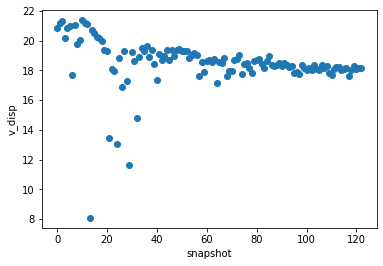

In [17]:
plt.scatter(np.arange(Nf), v_disp)
plt.xlabel("snapshot")
plt.ylabel("v_disp")


In [12]:
lguys.coords.to_skycoord(1, 2, 3)

NameError: name 'SkyCoord' is not defined

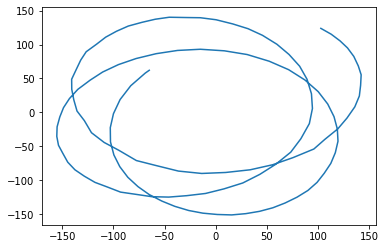

In [18]:
plt.plot(snap_xs[:, 1], snap_xs[:, 2])

MovieWriter ffmpeg unavailable; using Pillow instead.


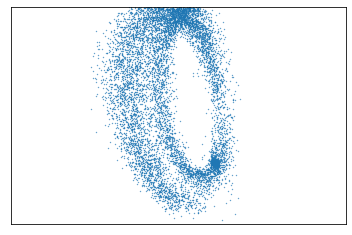

In [251]:
x, y, z = get_xy(f0)
fig = plt.figure()
scat = plt.scatter(x, z, s=0.1)

fnames = glob("orbits/out/snapshot*.hdf5")
plt.xlim(-180, 160)
plt.ylim(-150, 150)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    f = h5py.File(fnames[i], "r")
    x, y, z = get_xy(f)
    scat.set_offsets(np.array([x, y]).transpose())
    f.close()
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(len(fnames)),
                                  fargs=(scat,))

ani.save("orbit.gif", dpi=200)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


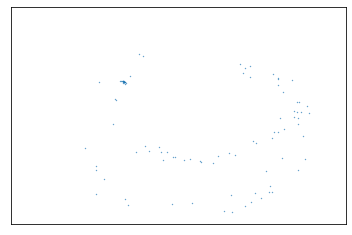

In [717]:
x, y, z = get_xy(f0)
IDs = f0["PartType1/ParticleIDs"][()]
filt = np.isin(IDs, ID_stars)

fig = plt.figure()
scat = plt.scatter(y[filt], z[filt], s=0.1)

fnames = glob("orbits/out/snapshot*.hdf5")
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.xticks([])
plt.yticks([])
    
def update_fig(i, scat):
    f = h5py.File(fnames[i], "r")
    IDs = f0["PartType1/ParticleIDs"][()]
    filt = np.isin(IDs, ID_stars)

    x, y, z = get_xy(f)
    scat.set_offsets(np.array([y[filt], z[filt]]).transpose())
    f.close()
    return scat, 
    
ani = mpl.animation.FuncAnimation(fig, update_fig, frames=range(len(fnames)),
                                  fargs=(scat,))

ani.save("stars.gif", dpi=200)
plt.show()

In [16]:
snap0 = lguys.Snapshot.file(filename)


In [17]:
snap0.v_x

AttributeError: 'Snapshot' object has no attribute 'v_x'

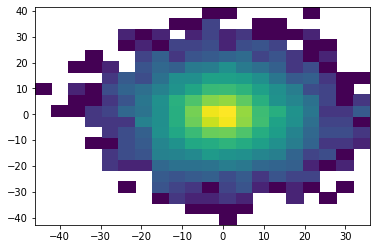

In [23]:
plt.hist2d(snap0.x, snap0.y, norm=mpl.colors.LogNorm(1, 1e3), cmin=1, bins=20);


In [26]:
filename_f = "orbits/out/snapshot_121.hdf5"
snap_f = lguys.Snapshot.file(filename_f)
center_snapshot(snap_f)

snapshot with 10000 particles

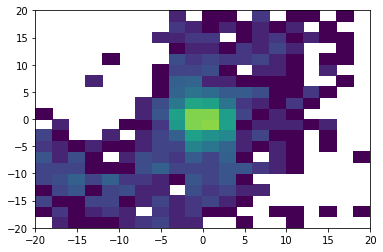

In [27]:
plt.hist2d(snap_f.x, snap_f.y, norm=mpl.colors.LogNorm(1, 1e3), cmin=1, bins=20, range=((-20, 20), (-20, 20)));

In [258]:
import astropy

In [ ]:
from astropy.coordinates import Galactocentric

In [ ]:
Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

Text(0, 0.5, 'v')

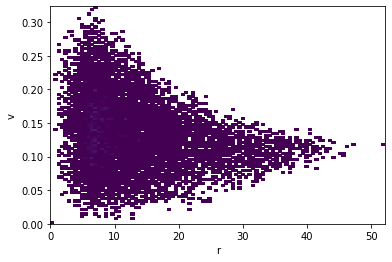

In [ ]:
plt.hist2d(r, v, norm=mpl.colors.LogNorm(10, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")

Text(0.5, 0, 'R')

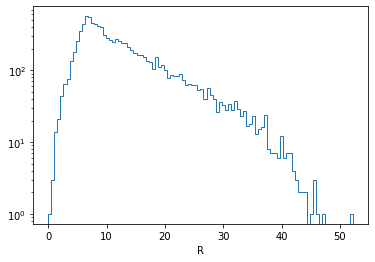

In [267]:
plt.hist(r, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

In [268]:
f1 = h5py.File("isolation/out/snapshot_001.hdf5", "r")

In [269]:
pos1 = f1["PartType1/Coordinates"][()]
x1 = pos1[:, 0]
y1 = pos1[:, 1]
z1 = pos1[:, 2]
r1 = np.sqrt(x1**2 + y1**2 + z1**2)
vel1 = f1["PartType1/Velocities"][()]
vx1 = vel1[:, 0]
xy1 = vel1[:, 1]
vz1 = vel1[:, 2]
v1 = np.sum(vel1**2, axis=1)
r1 = np.sum(pos1**2, axis=1)

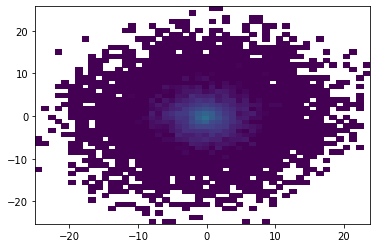

In [270]:
dx = 100
n_bin = 50
plt.hist2d(x1, y1, norm=mpl.colors.LogNorm(10, 1e5), cmin=1, bins=50);

Text(0.5, 0, 'R')

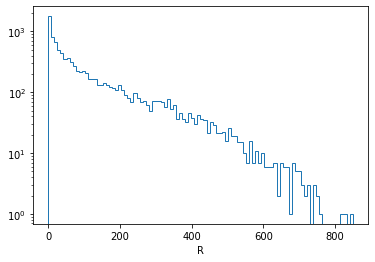

In [271]:
plt.hist(r1, 100, histtype="step")
plt.yscale("log")
plt.xlabel("R")

Text(0, 0.5, 'v')

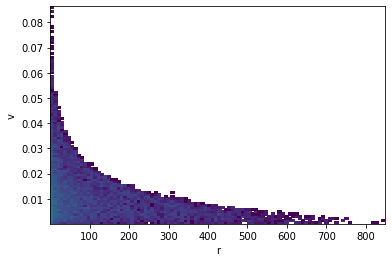

In [272]:
dx = 30
dy = 1e-10
n_bin = 50
plt.hist2d(r1, v1, norm=mpl.colors.LogNorm(1, 1e5), cmin=0, bins=100);
plt.xlabel("r")
plt.ylabel("v")

# Calculate stellar probabilities

In [636]:
f = h5py.File("orbits/out/snapshot_001.hdf5", "r")

G = 1
EPSREL = 1e-7

# profile scale radius and index
n = 1
rsS = 2 # kpc, input

EN = 20
DF_Nr = 20

In [670]:
p0 = get_most_bound(f)
r = np.array(get_rs(f, p0) )
filt = r > EPSREL
r = r[filt]
v0 = get_most_bound_v(f)

idx_sort = np.argsort(r)

N = len(r)
Mr = m * np.arange(N)


vx, vy, vz = get_vel(f, v0)

N = len(r)
m = f["Header"].attrs["MassTable"][1]
Φ = np.array(f["PartType1/Potential"][()])[filt][idx_sort]
IDs = np.array(f["PartType1/ParticleIDs"])[filt]
# Phi = -G * (Mr/r[idx_sort] + np.cumsum(m / r[idx_sort][::-1])[::-1])

In [638]:
E_kin = 1/2 * ( vx**2 + vy**2 + vz**2)
E_kin = np.array(E_kin)[filt]
Etot = E_kin + Phi[np.argsort(idx_sort)]

In [639]:
def ρ_star(r):
    return np.exp(-(r/rsS)**(1/n))

def ρ_s_int(r):
    return 4*np.pi * r**2 * ρ_star(r)

M_star = quad(ρ_s_int, 0., np.inf)[0]
M_star_r = np.vectorize(lambda x: quad(ρ_s_int, 0, x)[0])

In [640]:

DF_r_max = np.max(r)
DF_r_min = np.min(r[r > 2*EPSREL])
bins = np.logspace(np.log10(DF_r_min), np.log10(DF_r_max), num=DF_Nr)
DFr = 1/2 * (bins[1:] + bins[:-1])



In [641]:
NinS = quad(ρ_s_int, 0, DF_r_min)[0]  / M_star

NoutS = 1 - quad(ρ_s_int, 0, DF_r_max)[0]/M_star

In [642]:
psi = - np.interp(DFr, r[idx_sort], Phi)

nuDM, edges = np.histogram(r, bins=bins)
dV = (4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3))
nuDM = nuDM * m / dV

DF_rm = 1/2*(edges[1:] + edges[:-1])

In [643]:
nuS = ρ_star(DF_rm) / M_star

In [644]:
M_cum = np.interp(DF_rm, r[idx_sort], Mr)
M_star_cum = M_star_r(DF_rm)

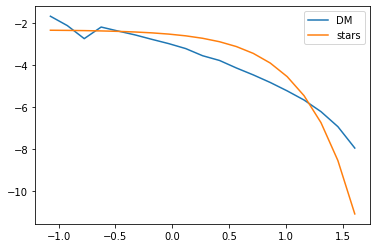

In [645]:
plt.plot(np.log10(DF_rm), np.log10(nuDM), label="DM")
plt.plot(np.log10(DF_rm), np.log10(nuS), label="stars")
plt.legend()

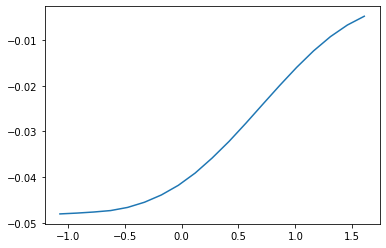

In [646]:
plt.plot(np.log10(DF_rm), -psi)

In [647]:
dndpDM   = np.gradient(nuDM,   psi)
d2nd2pDM = np.gradient(dndpDM, psi)
dndpS   = np.gradient(nuS,   psi)
d2nd2pS = np.gradient(dndpS, psi)

In [648]:
fS  = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pS[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) ) # + np.interp(0., psi, dndp) / np.sqrt(
fDM = np.vectorize( lambda e: 1./(np.sqrt(8)*np.pi**2) * (quad( lambda p:  np.interp(p, psi[::-1], d2nd2pDM[::-1]) / np.sqrt(e-p) , 0., e,  epsrel=EPSREL)[0]  ) )


In [649]:
E_max = psi[0]
E_min = E_max / EN

In [650]:
E = np.linspace(E_min, E_max, EN)

In [651]:
DF_stars = fS(E)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


In [652]:
DF_DM = fDM(E)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


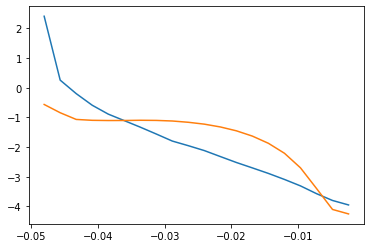

In [653]:
# plot DF vs -E
plt.plot(-E, np.log10(DF_DM))
plt.plot(-E, np.log10(DF_stars))

In [656]:
probs = np.interp(-Etot, E, DF_stars) / np.interp(-Etot, E, DF_DM)

In [657]:
probs /= np.sum(probs)

In [658]:
nuS_Nbody, edges = np.histogram(r, weights=probs, bins=bins)
nuS_Nbody = nuS_Nbody / dV

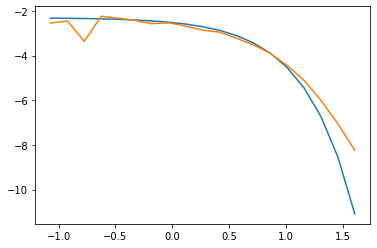

In [659]:
plt.plot(np.log10(DF_rm), np.log10(nuS))
plt.plot(np.log10(DF_rm), np.log10(nuS_Nbody))

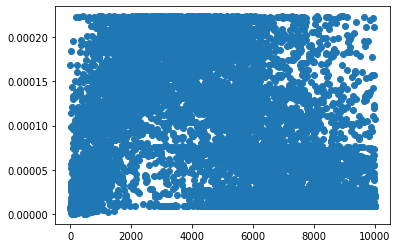

In [660]:
plt.scatter(IDs, probs)

In [677]:
Ns = 100

ID_stars = IDs[probs*Ns > np.random.uniform(size=N)]

In [678]:
ID_stars

array([6585, 1757, 6199, 8301, 5901, 9241, 5525, 6299, 5317, 4712, 3544,
       4881, 3919, 2567, 2268, 4004, 2704,  845, 3480, 2543, 4032, 5079,
       4900, 4434, 7866, 2922, 7808, 3012, 3392, 7035, 4949, 4260,  668,
       7411, 2350, 2908, 7919, 2665, 3415, 4543, 5664, 6713, 1769, 7046,
       3579, 6353, 3376,  747, 1984, 2777, 2869, 9339, 4147, 5897, 3018,
        813, 3998, 3713, 3960, 4871, 5977, 5077, 4454, 7051, 6476, 8873,
       6381, 3737, 3292, 5755, 2747, 2033, 3435, 1827, 4431, 7807, 5944,
       3047, 3379, 1906, 2386, 5454,  365, 3423, 1684, 1121, 1075,  603,
       1639, 1873, 2083, 4631, 3081, 3725, 2961, 5799, 7108, 8473, 5066],
      dtype=uint32)